In [2]:
#
# Purpose: to illustrate how to use h5py methods built
#          in Python to get the information from an HDF5 file 

# Date  :  July. 06, 2017

# In this example, we read "Radiance" and "MoonPhaseAngle" and their geolocation data datasets.
# then, data is processed to finally to create a geo-map


# importing the libraries needed
import numpy as np
import h5py
import rebind as rbw # this a local library, to use it is needed that the "rebind.py" 
                     #file should be located in the same directory where this program is executed
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import math
import os, fnmatch
from math import ceil, floor
from scipy.misc import bytescale

In [3]:
#
# opening the '.h5' file and reading our interest variables, for this case: 
# Latitude, Longitude, Radiance, MoonPhaseAngle
# note: all variables are in the same file but in 2 different groups into the .h5 file
#
dir_data    = '../Data/'
hfd_file = "GDNBO-SVDNB_npp_d20160831_t1816216_e1822020_b25103_c20161105035502773833_noaa_ops.h5"
basenameFile = os.path.basename(hfd_file)

f = h5py.File(dir_data+hfd_file,'r')
dnblat = f['All_Data/VIIRS-DNB-GEO_All/Latitude'][:]
dnblon = f['All_Data/VIIRS-DNB-GEO_All/Longitude'][:]
dnbrad = f['All_Data/VIIRS-DNB-SDR_All/Radiance'][:]
moonPhase = f['All_Data/VIIRS-DNB-GEO_All/MoonPhaseAngle'][:]
f.close()

/Users/lcastrogarcia/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/lcastrogarcia/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


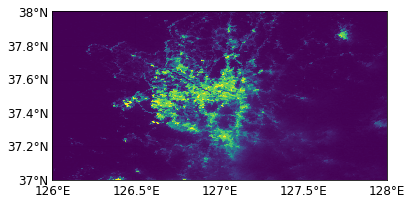

In [4]:
# reading the data dimensions
nps = dnbrad.shape[1]
nl 	= dnbrad.shape[0]

# defining the interest domain
ctrlat = 37.5
ctrlon = 127.0
latmax = 38  
latmin = 37  
lonmin = 126 
lonmax = 128 

# extracting data from our interest domain
result = np.where((dnblat >= latmin) & (dnblat <= latmax) & (dnblon >= lonmin) & (dnblon <= lonmax))

if len(result[0]) > 0:
  
	# locate the center point
	difflat = np.absolute(dnblat - ctrlat)
	difflon = np.absolute(dnblon - ctrlon)
	result = np.where((difflat + difflon) == np.min(difflat + difflon))
	nl0 = result[0][0]
	np0 = result[1][0]
    
	# pixel sizes
	nx = 250
	ny = 250

    # if the image edge is at the center
	if nl0 + ny > nl - 1:
		ny = nl - nl0 -1
	nlstart = nl0 * 1.0 - ny

	if nlstart < 0:
		nlstart=0.
    
    # get 250 by 250 pixels
	nll = nl0 + ny - nlstart + 1

    # must have two lines or more
	if nll > 2:
		npstart = np0 * 1.0 - nx
		if npstart < 0:
			npstart = 0
		if (np0+nx) > (nps-1):
			nx = nps - np0 - 1
		npp = np0 + nx - npstart + 1
		int_nlstart = int(nlstart); 
		int_npstart = int(npstart)
		data = dnbrad[int_nlstart:nl0+ny+1, int_npstart:np0+nx+1] * 1.e7
		lat  = dnblat[int_nlstart:nl0+ny+1, int_npstart:np0+nx+1]
		lon  = dnblon[int_nlstart:nl0+ny+1, int_npstart:np0+nx+1] 
		mag=5
		mindata = np.min(data)
		maxdata = np.max(data)
		
		new_dim = int(npp*mag)

		d = rbw.rebin(data, (new_dim,new_dim))
		dd = bytescale(d,0.0, 0.5, 180, 0)
		result = np.where(d > 0.5)

		if len(result[0]) > 0:
			dd[result] = 181 + bytescale(d[result], 0.5, 1.2, 255-181, 0)

		tmplat = rbw.rebin(lat, (new_dim,new_dim))
		tmplon = rbw.rebin(lon, (new_dim,new_dim))
        
		# plotting data
		m = Basemap(projection='cyl',llcrnrlat=latmin,urcrnrlat=latmax+.01,llcrnrlon=lonmin,\
                    urcrnrlon=lonmax,lat_ts=10,resolution='l')
		m.pcolormesh(tmplon, tmplat, (dd), latlon=True)
		parallels = np.arange(math.ceil(latmin),math.ceil(latmax+.01),.2)
		meridians = np.arange(math.ceil(lonmin),math.ceil(lonmax+1),.5)
		m.drawparallels(parallels,labels=[1,0,0,0],linewidth=0.01,labelstyle="N/S",fontsize=12)
		m.drawmeridians(meridians,labels=[0,0,0,1],linewidth=0.01,labelstyle="E/w",fontsize=12)
		image_name = "_".join((basenameFile.split('-')[1]).split('_')[0:5])
		plt.savefig(image_name + '.png', bbox_inches='tight', dpi=200)
		plt.show()
